<a href="https://www.kaggle.com/code/wenjuinloi/progress-forecast-machine-learning-model?scriptVersionId=146206793" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session





/kaggle/input/pipping/pipping data.csv


# **Introduction**



To understand the dynamics of productivity, work-trade ratios, and the efficiency of various work section has never been more crucial for construsction project.Hence to identify the correlation that affecting the productivity is essential , this project will be research on the correlation pipe errection productivity for Combine Cycle power plant from the analysed data to  devloped an Machine learning model to forecast the productivity based on the existing dataset. 



# **Objectives**

Our project aims to achieve the following objectives:

**Correlation Analysis:** To determine whether there is a statistically significant correlation between the perceived efficiency of each pipe materials and their respective work-trade ratios.

**Productivity Assessment:** To assess and compare the productivity levels of different disciplines, both in terms of output and efficiency, and understand how they relate to work-trade ratios.

**Identify Influencing Factors:** To identify potential influencing factors that contribute to the observed correlations, such as weather and the efficiency of supervisor for the job arrangement.

**Risk Management :** By developed an precise Machine learning Model we can forecast the productivity based on the manpower forecast hence it will serve as an guidance toward project manager for decision making ultimately mitigate the risk an ensure the project to be deliver within the budget and schedule. 



# **Data Analysis & Feature Selection :-** 

In [2]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex5 import *

/tmp/ipykernel_20/204811264.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


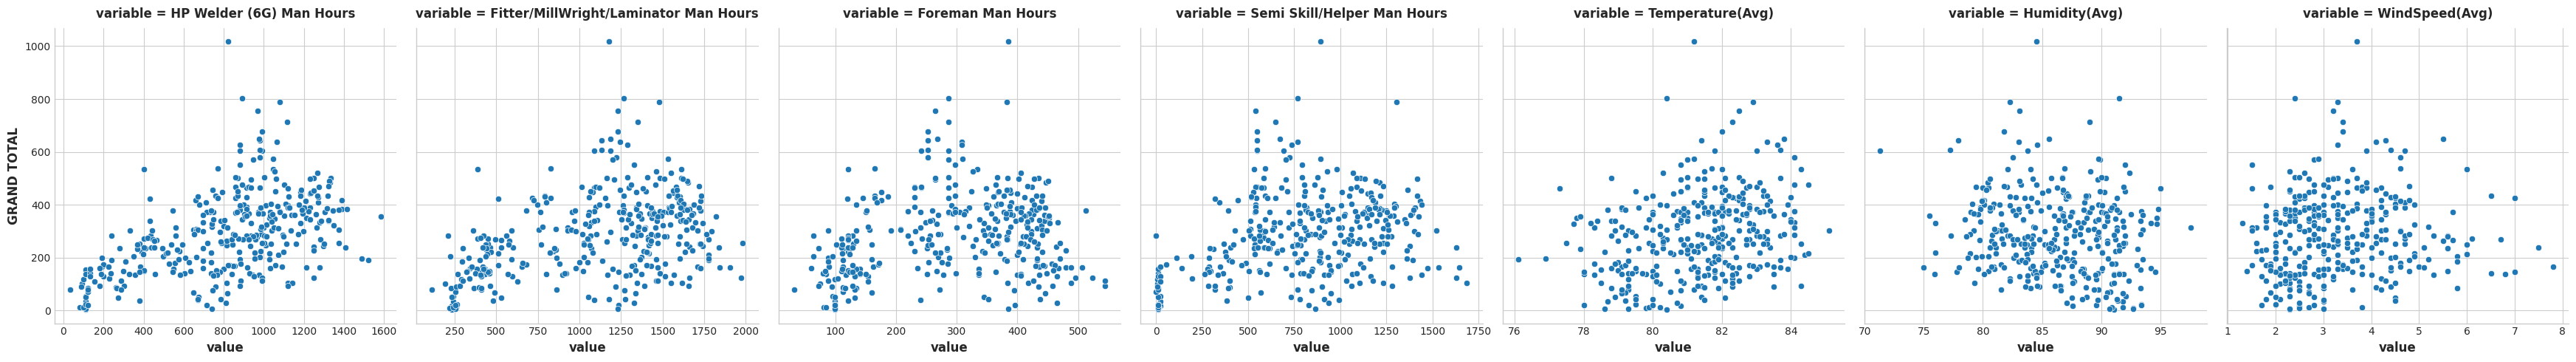

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import layers, callbacks


from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor



pipping = pd.read_csv('../input/pipping/pipping data.csv')

features = ["HP Welder (6G) Man Hours" , "Fitter/MillWright/Laminator Man Hours" , "Foreman Man Hours" , "Semi Skill/Helper Man Hours" , "Temperature(Avg)" ,  "Humidity(Avg)", "WindSpeed(Avg)"] 

sns.relplot(
    x="value", y="GRAND TOTAL", col="variable", data=pipping.melt(id_vars="GRAND TOTAL", value_vars=features), facet_kws=dict(sharex=False),
);

Interpration from the graph above.

i) we can see that the wind speed not correlated with our productivity hence this feautre will be drop to improve our ML model. 


ii) Based on the ploted graph we can see that the most productive usually are derive in the center of the graph hence we can validate the law of diminishing of return apply.

iii) Windspeed feature will be drop (There is no correlation based on the ploted graph).


AGP-CS-F                                 0.486821
HP Welder (6G) Man Hours                 0.367085
Fitter/MillWright/Laminator Man Hours    0.326088
AGP-CS-S                                 0.302181
AGP-AS-F                                 0.282324
Foreman Man Hours                        0.256320
HRSG_UNIT-21-AS-F                        0.225728
HRSG_UNIT-21-CS-F                        0.215648
Semi Skill/Helper Man Hours              0.187483
AGP-SS-F                                 0.171916
AGP-SS-S                                 0.131617
AGP-AS-S                                 0.104394
ST_UNIT-01-SS-F                          0.092449
Temperature(Avg)                         0.085683
HRSG_UNIT-11-CS-S                        0.070283
ST_UNIT-01-CS-F                          0.065559
GEN_UNIT-01-SS-F                         0.064262
Humidity(Avg)                            0.063974
GEN_UNIT-02-SS-F                         0.054427
UNIT-11-SS-F                             0.049470


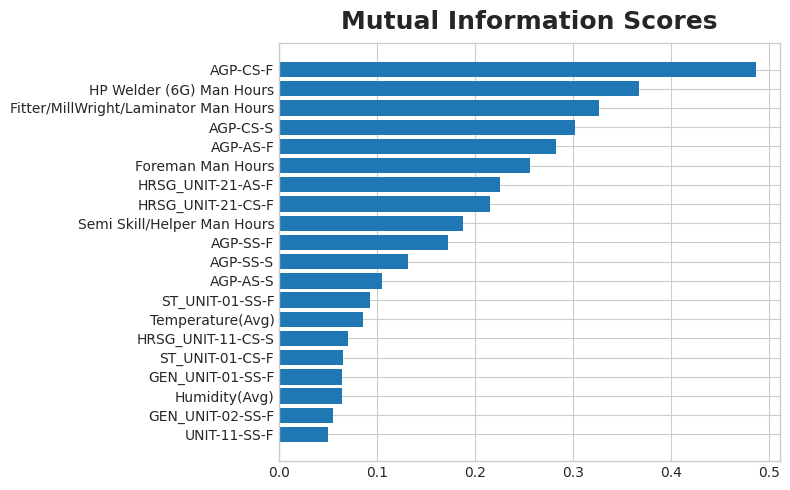

In [4]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
    




X = pipping.copy()
y = X.pop('GRAND TOTAL')

mi_scores = make_mi_scores(X, y)


print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

**From the Mutual information scores there is few points can be tell.

i) Most of the productivity will be derive by the Above Ground Piping , Field Weld Joint , Carbon Steel.

ii) For the trade of the worker, Fitter is the main factor of the productivity. **

# **Machine Learning Model (Selection & Validation) :-** 

For the current data set we will use few algorithms to shortlist the best of 2 algorithms for hyperparameter tunning (Algorithm is listed below)

i) Deep Learning 

ii) XGB Regressor

iii) Decision Tree

iv) Linear Regression

v) Elastic Net

vi) SGD Regressor

vii) Bayesian Ridge Regressor


**Splitting the data set for trainning and validation. **

In [5]:
X1=X.drop(columns=["Humidity(Avg)", 'Company_Code'])



scaler=StandardScaler()


X_train, X_valid, y_train, y_valid = train_test_split(X1, y,train_size=0.8, test_size=0.2,random_state=42)




X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape =  [X_train.shape[1]] 

print("Input shape: {}".format(input_shape))



Input shape: [47]


***Machine learning model** *

,Algorithm,MAE Score
3,Linear Regression,0.000282
6,Bayesian Ridge,0.000282
5,SGD Regressor,0.039054
1,XGB,0.431106
0,Deep Learning,0.445508
2,Decission Tree,0.684648
4,Elastic Net,0.869044


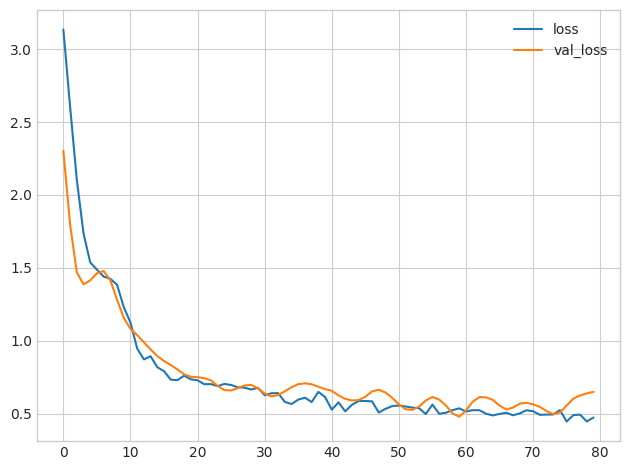

In [6]:

early_stopping = callbacks.EarlyStopping(
min_delta=0.001, # minimium amount of change to count as an improvement
patience=20, # how many epochs to wait before stopping
restore_best_weights=True,
)

model = keras.Sequential([
layers.Dense(128, activation='relu', input_shape=input_shape),
layers.Dropout(rate=0.3),
layers.Dense(128, activation='relu'),
layers.Dropout(rate=0.3),
layers.Dense(128, activation='relu'),
layers.Dropout(rate=0.3),
layers.Dense(1)
])

model.compile(
optimizer='adam',
loss='mae',metrics=['accuracy','mae']
)

history = model.fit(
X_train, y_train,
validation_data=(X_valid, y_valid),
batch_size=250,
epochs=100,
callbacks=[early_stopping],
verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()


deeplearningmae=history_df['mae'].min()




def xgb(X_train, y_train, X_valid, y_valid):

 modelxgb = XGBRegressor(random_state=0)

 modelxgb.fit(X_train, y_train)

 predictions = modelxgb.predict(X_valid)

 
 


 return mean_absolute_error(predictions, y_valid)


xgbmae=xgb(X_train, y_train, X_valid, y_valid)



def dectree(X_train, y_train, X_valid, y_valid):
    
    modeltree = DecisionTreeRegressor(random_state=0)
    
    modeltree.fit(X_train, y_train)
    
    predictions = modeltree.predict(X_valid)
    
    return mean_absolute_error(predictions, y_valid)


dectreemae=dectree(X_train, y_train, X_valid, y_valid)


def linearregression(X_train, y_train, X_valid, y_valid):
    
    model = LinearRegression()
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_valid)
    
    return mean_absolute_error(predictions, y_valid)
    
    
linearregressionmae=linearregression(X_train, y_train, X_valid, y_valid)




def elasticnetregression(X_train, y_train, X_valid, y_valid):
    
    model = ElasticNet()
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_valid)
    
    return mean_absolute_error(predictions, y_valid)
    
    
elasticnetregressionmae=elasticnetregression(X_train, y_train, X_valid, y_valid)


def sgdregression(X_train, y_train, X_valid, y_valid):
    
    model = SGDRegressor()
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_valid)
    
    return mean_absolute_error(predictions, y_valid)
    
    
sgdregressionmae=sgdregression(X_train, y_train, X_valid, y_valid)


def bayridregression(X_train, y_train, X_valid, y_valid):
    
    model = BayesianRidge()
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_valid)
    
    return mean_absolute_error(predictions, y_valid)
    
    
bayridregression(X_train, y_train, X_valid, y_valid)

bayridregressionmae=bayridregression(X_train, y_train, X_valid, y_valid)


mlmae = {'Algorithm':['Deep Learning', 'XGB', 'Decission Tree', 'Linear Regression', 'Elastic Net', 'SGD Regressor', 'Bayesian Ridge'],'MAE Score': [deeplearningmae,xgbmae,dectreemae,linearregressionmae,elasticnetregressionmae,sgdregressionmae,bayridregressionmae]}
dfmlmae = pd.DataFrame(data=mlmae)

sorteddfmlmae = dfmlmae.sort_values(by='MAE Score', ascending=True)



sorteddfmlmae.head(8)





i) Based on the benchmark above (MAE as metrics) we can see that the Linear Regression Model and Baeysian Ridge Regression model will be out peform compare to the others model hence these two models     will be shortlistes for hyper parameter tunning.

ii) Based on the history graph from deep learning model the gap between the loss and are validation loss are close hence the "noise" level in this dataset are acceptable. 

# **Hyper Parameter tunning by using (Grid Search & Randomized Search) :-** 

In [7]:
def Gridsearchlinearreg(X1,y):
 space = dict()
 space['copy_X'] = [True, False]
 space['fit_intercept'] = [True, False]
 space['n_jobs'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
 space['positive'] = [True, False]

 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)



 model = LinearRegression()
 search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)

 result = search.fit(X1,y)


 print('Best Score Linear Regression : %s' % result.best_score_)
 print('Best Hyperparameters Linear Regression: %s' % result.best_params_)
    
    


def Gridsearchbayridregression(X1,y):
    
 space = dict()
 space['alpha_1'] = [1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
 space['alpha_2'] = [1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
 space['alpha_init'] = [1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
 space['compute_score'] = [True , False]
 space['copy_X'] = [True, False]
 space['fit_intercept'] = [True , False]
 space['lambda_1'] = [1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
 space['lambda_2'] = [1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
 space['lambda_init'] = [1, 10, 100]
 space['n_iter'] = [1,300]
 space['tol'] = [1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

 model = BayesianRidge()
 search = RandomizedSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)

 result = search.fit(X1,y)


 print('Best Score: %s' % result.best_score_)
 print('Best Hyperparameters: %s' % result.best_params_)

    
    
    

Gridsearchlinearreg(X1,y)

Gridsearchbayridregression(X1,y)







/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1200 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_base.py", line 642, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklear

Best Score Linear Regression : -0.10981481481494099
Best Hyperparameters Linear Regression: {'copy_X': True, 'fit_intercept': False, 'n_jobs': 1, 'positive': True}
Best Score: -0.10688895983114019
Best Hyperparameters: {'tol': 1e-06, 'n_iter': 300, 'lambda_init': 100, 'lambda_2': 0.0001, 'lambda_1': 100, 'fit_intercept': False, 'copy_X': True, 'compute_score': True, 'alpha_init': 0.01, 'alpha_2': 1e-06, 'alpha_1': 0.0001}
